### TFM - Predicción de los precios de Alquiler a partir de las características.

Importación de librerías necesarias para el desarrollo.


In [1]:
# Import de todo las librerías que podemos llegar a usar.
import pandas as pd
import io
from google.colab import files

import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

from scipy import cluster
import sklearn.neighbors
from sklearn import preprocessing 
from sklearn.decomposition import PCA

import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import kneighbors_graph

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None
%matplotlib inline

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Hacemos esa primera lectura del dataset, contar, filas, columnas, tipos de datos.

In [3]:
#Lectura del dataset
pisos_bilbao = pd.read_csv('/content/pisos_bilbao.csv', ',' , encoding= 'unicode_escape')
pisos_bilbao.head(5)

,Habitaciones,Banhos,Superficie,Barrio,Renta,Precio
0,2,1,75,8,18165,750
1,1,1,45,0,40300,780
2,4,2,220,0,40300,1550
3,3,2,87,1,40401,1200
4,1,1,45,0,40300,950


# Problema de clasificación

Text(0, 0.5, 'Número de pisos')

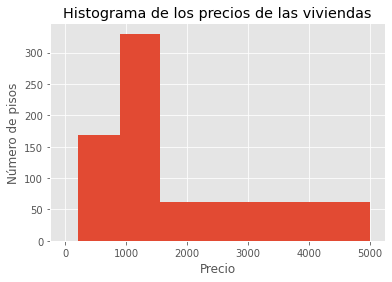

In [4]:
# matplotlib histogram
plt.hist(pisos_bilbao['Precio'],bins =[0,200,900,1550,5000])
# Así las clases quedan más repartidas
# Add labels
plt.title('Histograma de los precios de las viviendas')
plt.xlabel('Precio')
plt.ylabel('Número de pisos')

In [5]:
features = pisos_bilbao[['Habitaciones', 'Banhos', 'Superficie', 
                  'Barrio', 'Renta', 'Precio']]
rango_precios = [0,200,900,1750,5000]
names = ['E', 'B', 'M', 'C']
rango_preciosN = pd.cut(features.loc[:, ('Precio')], rango_precios, labels = names)
Precio_letras = rango_preciosN
Precio_letras

0      B
1      B
2      M
3      M
4      M
      ..
555    M
556    C
557    M
558    M
559    M
Name: Precio, Length: 560, dtype: category
Categories (4, object): ['E' < 'B' < 'M' < 'C']

In [6]:
atributos = features.loc[:, ( 'Habitaciones', 'Banhos', 'Superficie', 'Renta', 'Barrio')]
pisos_bilbao = pd.concat([atributos, Precio_letras], axis=1)
pisos_bilbao.head()

,Habitaciones,Banhos,Superficie,Renta,Barrio,Precio
0,2,1,75,18165,8,B
1,1,1,45,40300,0,B
2,4,2,220,40300,0,M
3,3,2,87,40401,1,M
4,1,1,45,40300,0,M


In [7]:
pisos_bilbao = pisos_bilbao[pisos_bilbao.Precio != 'E']

pisos_bilbao = pisos_bilbao[pisos_bilbao.Superficie > 0]
pisos_bilbao = pisos_bilbao[pisos_bilbao.Banhos > 0]
pisos_bilbao

,Habitaciones,Banhos,Superficie,Renta,Barrio,Precio
0,2,1,75,18165,8,B
1,1,1,45,40300,0,B
2,4,2,220,40300,0,M
3,3,2,87,40401,1,M
4,1,1,45,40300,0,M
...,...,...,...,...,...,...
555,3,2,110,40300,0,M
556,1,1,100,40300,0,C
557,2,2,85,40401,1,M
558,2,2,71,40300,0,M


Text(0, 0.5, 'Número de pisos')

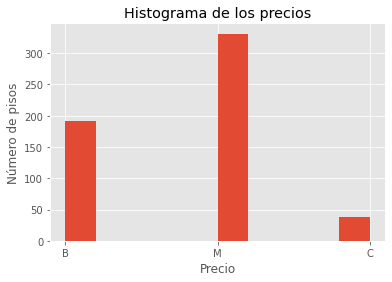

In [8]:
# matplotlib histogram
plt.hist(pisos_bilbao['Precio'])
# Así las clases quedan más repartidas
# Add labels
plt.title('Histograma de los precios')
plt.xlabel('Precio')
plt.ylabel('Número de pisos')

##### Tres variables

###### Regresión logística

In [9]:
#Importaciones varias para la evaluación

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import plot_confusion_matrix

# Configuración de la evaluación

def evaluar_modelo(modelo, test_data, test_labels):
    prediction = modelo.predict(test_data)
    print('Rendimiento obtenido:',accuracy_score(test_labels,prediction))
    print('Reporte de indicadores:\n',classification_report(test_labels,prediction))
    print('Matriz de confusión:')
    cf = plot_confusion_matrix(modelo,test_data,test_labels,cmap='Blues_r',values_format='d')

In [10]:
# División aleatoria pero con la librería model_selection
from sklearn.model_selection import train_test_split 

Bilbao_train, Bilbao_test = train_test_split(pisos_bilbao, test_size = 0.20, random_state = 78)
# Advertir de los parámetros interesantes como stratify

# Quitarlo para que no se vea que tenemos esto aquí, ya queda claro con que nos quedamos un 30 por ciento
print("Ejemplos usados para entrenar: ", len(Bilbao_train))
print("Ejemplos usados para test: ", len(Bilbao_test))

Ejemplos usados para entrenar:  448
Ejemplos usados para test:  112


In [11]:
# Nos quedamos solo con las variables que más correlación tienen de momento
selected_features = ['Habitaciones', 'Banhos', 
                     'Superficie'   
                    ]
labels_train = Bilbao_train.Precio.values 
labels_test = Bilbao_test.Precio.values                   

In [12]:
# Estandarizamos las variables.
m_standarizar = preprocessing.StandardScaler()
X_train = m_standarizar.fit_transform(Bilbao_train[selected_features])
X_test = m_standarizar.transform(Bilbao_test[selected_features])

In [13]:
rl_a = LogisticRegression(solver = 'liblinear', random_state=78) 
rl_a.fit(X_train, labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=78, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
kf = KFold(n_splits=5)
score = rl_a.score(X_train,labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(rl_a, X_train, labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.7321428571428571
Metricas cross_validation [0.68888889 0.74444444 0.74444444 0.71910112 0.71910112]
Media de cross_validation 0.7231960049937578


Rendimiento obtenido: 0.7589285714285714
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.68      0.87      0.76        31
           C       1.00      0.09      0.17        11
           M       0.80      0.81      0.81        70

    accuracy                           0.76       112
   macro avg       0.83      0.59      0.58       112
weighted avg       0.79      0.76      0.73       112

Matriz de confusión:


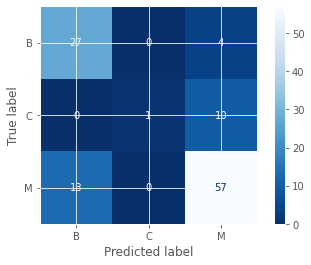

In [15]:
evaluar_modelo(rl_a, X_test, labels_test)

###### Arbol de decisión

Rendimiento obtenido: 0.7589285714285714
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.71      0.87      0.78        31
           C       0.40      0.18      0.25        11
           M       0.81      0.80      0.81        70

    accuracy                           0.76       112
   macro avg       0.64      0.62      0.61       112
weighted avg       0.74      0.76      0.74       112

Matriz de confusión:


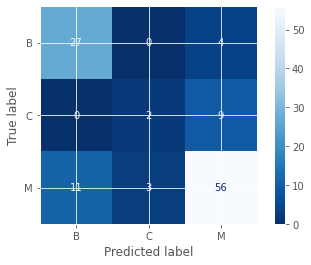

In [16]:
ad_a = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=78)
ad_a.fit(Bilbao_train[selected_features], labels_train)

evaluar_modelo(ad_a, Bilbao_test[selected_features], labels_test)

In [17]:
kf = KFold(n_splits=5)
score = ad_a.score(Bilbao_train[selected_features],labels_train)
print("Metrica del modelo de enrenamiento", score)
scores = cross_val_score(ad_a, Bilbao_train[selected_features], labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de enrenamiento 0.7879464285714286
Metricas cross_validation [0.7        0.72222222 0.75555556 0.71910112 0.70786517]
Media de cross_validation 0.7209488139825219


###### SVM

Rendimiento obtenido: 0.7857142857142857
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.71      0.87      0.78        31
           C       1.00      0.18      0.31        11
           M       0.82      0.84      0.83        70

    accuracy                           0.79       112
   macro avg       0.84      0.63      0.64       112
weighted avg       0.81      0.79      0.77       112

Matriz de confusión:


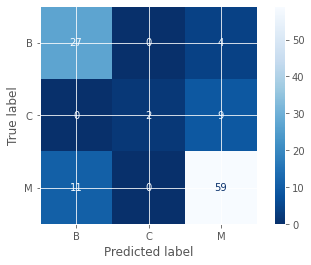

In [18]:
svc_a = SVC(C = 10, kernel = 'rbf', random_state=78)
ovo = OneVsOneClassifier(svc_a)
ovo.fit(X_train, labels_train)
evaluar_modelo(ovo, X_test, labels_test)

In [19]:
kf = KFold(n_splits=5)
score = ovo.score(X_train,labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ovo, X_train, labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.7700892857142857
Metricas cross_validation [0.71111111 0.76666667 0.76666667 0.70786517 0.73033708]
Media de cross_validation 0.7365293383270911


###### GradientBoosting

Rendimiento obtenido: 0.75
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.68      0.87      0.76        31
           C       0.00      0.00      0.00        11
           M       0.79      0.81      0.80        70

    accuracy                           0.75       112
   macro avg       0.49      0.56      0.52       112
weighted avg       0.68      0.75      0.71       112

Matriz de confusión:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


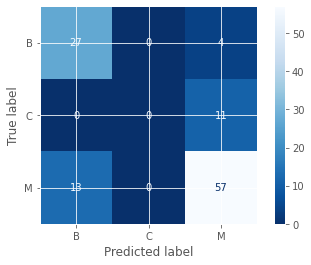

In [20]:
gb_a = GradientBoostingClassifier(n_estimators=8, max_features='auto', random_state=78)

gb_a.fit(Bilbao_train[selected_features], labels_train)
# Prueba Nro. 1
evaluar_modelo(gb_a, Bilbao_test[selected_features], labels_test)

In [21]:
kf = KFold(n_splits=5)
score = gb_a.score(Bilbao_train[selected_features],labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(gb_a, X_train, labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.7611607142857143
Metricas cross_validation [0.68888889 0.78888889 0.62222222 0.68539326 0.73033708]
Media de cross_validation 0.7031460674157304


##### Tres variables más barrio


###### Rregresión Logística

In [22]:
# Nos quedamos solo con las variables que más correlación tienen de momento
selected_features = ['Habitaciones', 'Banhos', 
                     'Superficie' , 'Barrio'  
                    ]
labels_train = Bilbao_train.Precio.values 
labels_test = Bilbao_test.Precio.values   

# Estandarizamos las variables.
m_standarizar = preprocessing.StandardScaler()
X_train = m_standarizar.fit_transform(Bilbao_train[selected_features])
X_test = m_standarizar.transform(Bilbao_test[selected_features])

rl_b = LogisticRegression(solver = 'liblinear', random_state=78) 
rl_b.fit(X_train, labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=78, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Rendimiento obtenido: 0.7678571428571429
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.69      0.87      0.77        31
           C       1.00      0.09      0.17        11
           M       0.81      0.83      0.82        70

    accuracy                           0.77       112
   macro avg       0.83      0.60      0.58       112
weighted avg       0.79      0.77      0.74       112

Matriz de confusión:


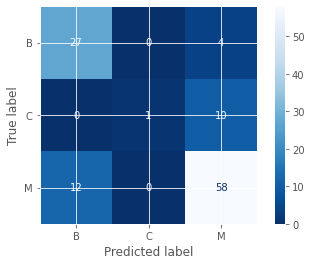

In [23]:
evaluar_modelo(rl_b, X_test, labels_test)

In [24]:
kf = KFold(n_splits=5)
score = rl_b.score(X_train,labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(rl_b, X_train, labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.7544642857142857
Metricas cross_validation [0.71111111 0.77777778 0.72222222 0.69662921 0.75280899]
Media de cross_validation 0.7321098626716604


###### Arbol de decisión

Rendimiento obtenido: 0.75
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.70      0.74      0.72        31
           C       0.60      0.27      0.37        11
           M       0.78      0.83      0.81        70

    accuracy                           0.75       112
   macro avg       0.69      0.61      0.63       112
weighted avg       0.74      0.75      0.74       112

Matriz de confusión:


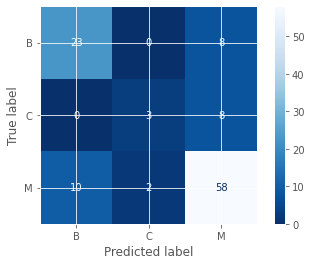

In [25]:
ad_b = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=78)
ad_b.fit(Bilbao_train[selected_features], labels_train)

evaluar_modelo(ad_b, Bilbao_test[selected_features], labels_test)

In [26]:
kf = KFold(n_splits=5)
score = ad_b.score(Bilbao_train[selected_features],labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ad_b, Bilbao_train[selected_features], labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.84375
Metricas cross_validation [0.76666667 0.77777778 0.7        0.73033708 0.66292135]
Media de cross_validation 0.7275405742821474


###### SVM

Rendimiento obtenido: 0.8035714285714286
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.76      0.84      0.80        31
           C       1.00      0.18      0.31        11
           M       0.82      0.89      0.85        70

    accuracy                           0.80       112
   macro avg       0.86      0.64      0.65       112
weighted avg       0.82      0.80      0.78       112

Matriz de confusión:


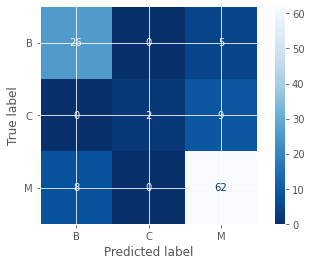

In [27]:
svc_b = SVC(C = 10, kernel = 'rbf', random_state=78, gamma='auto')
ovo = OneVsOneClassifier(svc_b)
ovo.fit(X_train, labels_train)
evaluar_modelo(ovo, X_test, labels_test)

In [28]:
kf = KFold(n_splits=5)
score = ovo.score(X_train,labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ovo, X_train, labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.8102678571428571
Metricas cross_validation [0.75555556 0.77777778 0.77777778 0.71910112 0.73033708]
Media de cross_validation 0.7521098626716605


###### GradienteBoostingclasificación

Rendimiento obtenido: 0.75
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.69      0.81      0.75        31
           C       0.00      0.00      0.00        11
           M       0.78      0.84      0.81        70

    accuracy                           0.75       112
   macro avg       0.49      0.55      0.52       112
weighted avg       0.68      0.75      0.71       112

Matriz de confusión:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


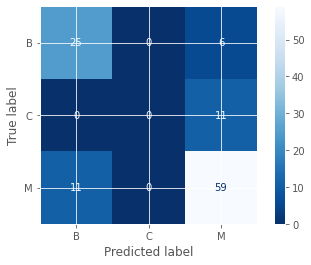

In [29]:
gb_b = GradientBoostingClassifier(n_estimators=8, max_features='auto', random_state=78)

gb_b.fit(Bilbao_train[selected_features], labels_train)
# Prueba Nro. 1
evaluar_modelo(gb_b, Bilbao_test[selected_features], labels_test)

In [30]:
kf = KFold(n_splits=5)
score = gb_b.score(Bilbao_train[selected_features],labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(gb_b, Bilbao_train[selected_features], labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.7879464285714286
Metricas cross_validation [0.74444444 0.78888889 0.66666667 0.69662921 0.74157303]
Media de cross_validation 0.7276404494382022


##### Tres variables más renta

###### Regresión Logística


In [31]:
# Nos quedamos solo con las variables que más correlación tienen de momento
selected_features = ['Habitaciones', 'Banhos', 
                     'Superficie' , 'Renta'  
                    ]
                    
labels_train = Bilbao_train.Precio.values 
labels_test = Bilbao_test.Precio.values   
m_standarizar = preprocessing.StandardScaler()
X_train = m_standarizar.fit_transform(Bilbao_train[selected_features])
X_test = m_standarizar.transform(Bilbao_test[selected_features])

rl_c = LogisticRegression(solver = 'liblinear', random_state=78) 
rl_c.fit(X_train, labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=78, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Rendimiento obtenido: 0.7767857142857143
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.71      0.87      0.78        31
           C       1.00      0.09      0.17        11
           M       0.81      0.84      0.83        70

    accuracy                           0.78       112
   macro avg       0.84      0.60      0.59       112
weighted avg       0.80      0.78      0.75       112

Matriz de confusión:


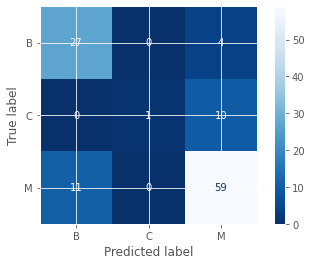

In [32]:
evaluar_modelo(rl_c, X_test, labels_test)

In [33]:
kf = KFold(n_splits=5)
score = rl_c.score(X_train,labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(rl_c, X_train, labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.7433035714285714
Metricas cross_validation [0.71111111 0.74444444 0.72222222 0.70786517 0.75280899]
Media de cross_validation 0.7276903870162297


###### Arbol de decisión

Rendimiento obtenido: 0.75
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.68      0.84      0.75        31
           C       0.50      0.18      0.27        11
           M       0.80      0.80      0.80        70

    accuracy                           0.75       112
   macro avg       0.66      0.61      0.61       112
weighted avg       0.74      0.75      0.73       112

Matriz de confusión:


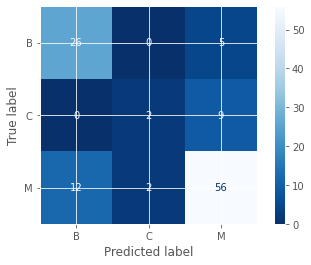

In [34]:
ad_c = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=78)
ad_c.fit(Bilbao_train[selected_features], labels_train)
 
evaluar_modelo(ad_c, Bilbao_test[selected_features], labels_test)

In [35]:
kf = KFold(n_splits=5)
score = ad_c.score(Bilbao_train[selected_features],labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ad_c, Bilbao_train[selected_features], labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.8191964285714286
Metricas cross_validation [0.75555556 0.77777778 0.78888889 0.70786517 0.70786517]
Media de cross_validation 0.7475905118601747


###### SVM

Rendimiento obtenido: 0.8035714285714286
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.79      0.84      0.81        31
           C       1.00      0.09      0.17        11
           M       0.81      0.90      0.85        70

    accuracy                           0.80       112
   macro avg       0.87      0.61      0.61       112
weighted avg       0.82      0.80      0.77       112

Matriz de confusión:


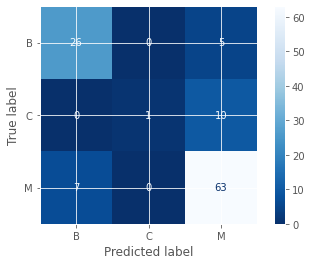

In [36]:
svm_c = SVC(C = 10, kernel = 'rbf', random_state=78)
ovo = OneVsOneClassifier(svm_c)
ovo.fit(X_train, labels_train)
evaluar_modelo(ovo, X_test, labels_test)

In [37]:
kf = KFold(n_splits=5)
score = ovo.score(X_train,labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ovo, X_train, labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.8013392857142857
Metricas cross_validation [0.75555556 0.8        0.74444444 0.73033708 0.74157303]
Media de cross_validation 0.7543820224719101


###### GradientBoosting

Rendimiento obtenido: 0.7678571428571429
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.74      0.81      0.77        31
           C       0.00      0.00      0.00        11
           M       0.78      0.87      0.82        70

    accuracy                           0.77       112
   macro avg       0.51      0.56      0.53       112
weighted avg       0.69      0.77      0.73       112

Matriz de confusión:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


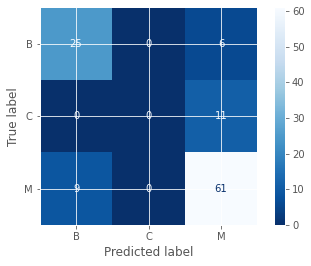

In [38]:
gb_c = GradientBoostingClassifier(n_estimators=10, max_features='auto', random_state=78)

gb_c.fit(Bilbao_train[selected_features], labels_train)

evaluar_modelo(gb_c, Bilbao_test[selected_features], labels_test)

In [39]:
kf = KFold(n_splits=5)
score = gb_c.score(Bilbao_train[selected_features],labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(gb_c, Bilbao_train[selected_features], labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.7879464285714286
Metricas cross_validation [0.73333333 0.8        0.67777778 0.70786517 0.74157303]
Media de cross_validation 0.7321098626716604


##### Todas las variables

###### Regresión Logística

In [40]:
# Nos quedamos solo con las variables que más correlación tienen de momento
selected_features = ['Habitaciones', 'Banhos', 
                     'Superficie' , 'Barrio', 'Renta'
                    ]
                    
labels_train = Bilbao_train.Precio.values 
labels_test = Bilbao_test.Precio.values   


m_standarizar = preprocessing.StandardScaler()
X_train = m_standarizar.fit_transform(Bilbao_train[selected_features])
X_test = m_standarizar.transform(Bilbao_test[selected_features])

rl_d = LogisticRegression(solver = 'liblinear', random_state=78) 
rl_d.fit(X_train, labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=78, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Rendimiento obtenido: 0.7678571428571429
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.69      0.87      0.77        31
           C       1.00      0.09      0.17        11
           M       0.81      0.83      0.82        70

    accuracy                           0.77       112
   macro avg       0.83      0.60      0.58       112
weighted avg       0.79      0.77      0.74       112

Matriz de confusión:


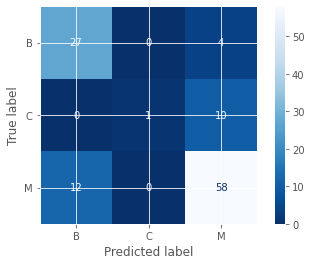

In [41]:
evaluar_modelo(rl_d, X_test, labels_test)

In [42]:
kf = KFold(n_splits=5)
score = rl_d.score(X_train,labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(rl_d, X_train, labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.7522321428571429
Metricas cross_validation [0.7        0.78888889 0.71111111 0.70786517 0.75280899]
Media de cross_validation 0.7321348314606742


###### Arbol de decisión

Rendimiento obtenido: 0.75
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.70      0.74      0.72        31
           C       0.60      0.27      0.37        11
           M       0.78      0.83      0.81        70

    accuracy                           0.75       112
   macro avg       0.69      0.61      0.63       112
weighted avg       0.74      0.75      0.74       112

Matriz de confusión:


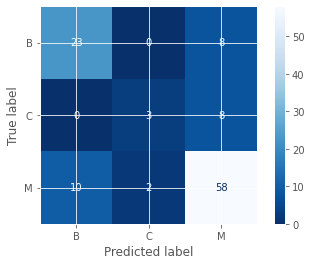

In [43]:
ad_d = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=78)
ad_d.fit(Bilbao_train[selected_features], labels_train)

evaluar_modelo(ad_d, Bilbao_test[selected_features], labels_test)

In [44]:
kf = KFold(n_splits=5)
score = ad_d.score(Bilbao_train[selected_features],labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ad_d, Bilbao_train[selected_features], labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.8459821428571429
Metricas cross_validation [0.76666667 0.77777778 0.8        0.73033708 0.65168539]
Media de cross_validation 0.7452933832709114


###### SVM

Rendimiento obtenido: 0.7946428571428571
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.76      0.81      0.78        31
           C       1.00      0.18      0.31        11
           M       0.81      0.89      0.84        70

    accuracy                           0.79       112
   macro avg       0.85      0.62      0.64       112
weighted avg       0.81      0.79      0.77       112

Matriz de confusión:


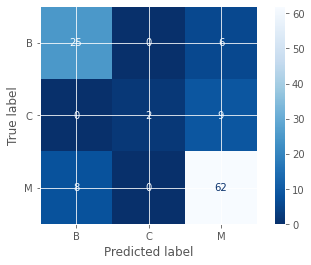

In [45]:
svc_d = SVC(C = 10, kernel = 'rbf', random_state=78)
ovo = OneVsOneClassifier(svc_d)
ovo.fit(X_train, labels_train)
evaluar_modelo(ovo, X_test, labels_test)

In [46]:
kf = KFold(n_splits=5)
score = ovo.score(X_train,labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(ovo, X_train, labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.8236607142857143
Metricas cross_validation [0.76666667 0.75555556 0.78888889 0.73033708 0.73033708]
Media de cross_validation 0.7543570536828964


###### GradientBoosting

Rendimiento obtenido: 0.75
Reporte de indicadores:
               precision    recall  f1-score   support

           B       0.69      0.81      0.75        31
           C       0.00      0.00      0.00        11
           M       0.78      0.84      0.81        70

    accuracy                           0.75       112
   macro avg       0.49      0.55      0.52       112
weighted avg       0.68      0.75      0.71       112

Matriz de confusión:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


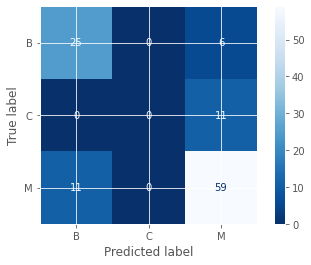

In [47]:
gb_d = GradientBoostingClassifier(n_estimators=10, max_features='auto', random_state=78)

gb_d.fit(Bilbao_train[selected_features], labels_train)
# Prueba Nro. 1
evaluar_modelo(gb_d, Bilbao_test[selected_features], labels_test)

In [48]:
kf = KFold(n_splits=5)
score = gb_d.score(Bilbao_train[selected_features],labels_train)
print("Metrica del modelo de entrenamiento", score)
scores = cross_val_score(gb_d, Bilbao_train[selected_features], labels_train, cv=kf, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Metrica del modelo de entrenamiento 0.7991071428571429
Metricas cross_validation [0.74444444 0.8        0.65555556 0.70786517 0.74157303]
Media de cross_validation 0.7298876404494382
